In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import nibabel as nb
#from nilearn.image import resample_img
from sklearn import preprocessing
import matplotlib.colors as colors

In [2]:
func_file = 'sub-0050002_ses-1_task-rest_run-1_func_reorient.nii.gz'
mask_file = 'sub-0050002_ses-1_task-rest_run-1_functional_brain_mask.nii.gz'

In [3]:
# read in and mask the data 
func = nb.load(func_file)
mask = nb.load(mask_file)
mask_affine = mask.get_affine()
mask = mask.get_data()

new_shape = func.shape[0]*func.shape[1]*func.shape[2]
func = func.get_data()
func = np.resize(func, (new_shape,func.shape[-1] ))

func = func[np.where( mask.ravel() == 1 )[0], :]

/Users/cameron.craddock/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


In [4]:
# z-score the rows so that they can be viewed on the same image
func = preprocessing.scale(func, axis=1)

/Users/cameron.craddock/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


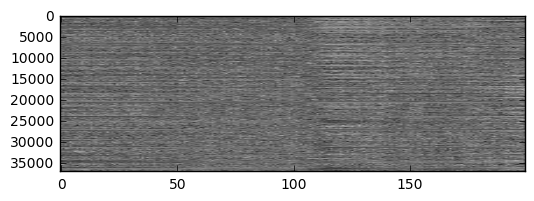

In [5]:
aspect = (float(func.shape[1])/float(func.shape[0]))/3.0
plt.imshow(func,cmap='gray', aspect=aspect)

In [33]:
# now try some basic reordering
from sklearn.cluster.bicluster import SpectralBiclustering
model = SpectralBiclustering(n_clusters=(5,1), method='log',
                             random_state=0)
model.fit(func)

In [34]:
reordered_func=func[np.argsort(model.row_labels_)]

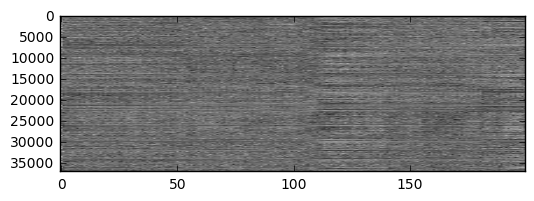

In [35]:
plt.imshow(reordered_func,cmap='gray', aspect=aspect)

In [36]:
out_clusters=np.zeros(np.shape(func[:,0]))
for i in range(0,5):
    print i, model.get_indices(i)[0]
    out_clusters[model.get_indices(i)[0]]=i+1

0 [    1     4     9 ..., 37003 37018 37019]
1 [    0     3     6 ..., 36979 37000 37004]
2 [   75    88   202 ..., 37014 37016 37017]
3 [   12    18    51 ..., 36963 36992 36994]
4 [    2     5    58 ..., 37008 37013 37015]


In [44]:
out_clusters_img=np.zeros(np.prod(mask.shape))
out_clusters_img[mask.ravel()==1]=out_clusters

In [45]:
out_clusters_img=out_clusters_img.reshape(mask.shape)
print np.unique(out_clusters_img)

[ 0.  1.  2.  3.  4.  5.]


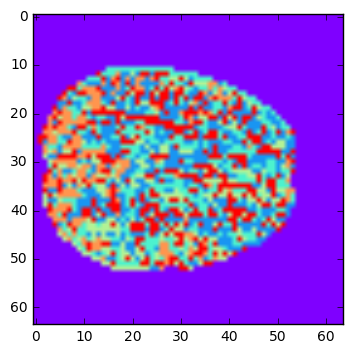

In [46]:
plt.imshow(out_clusters_img[:,:,18],cmap='rainbow',interpolation=None)

In [47]:
clust_img=nb.Nifti1Image(out_clusters_img, mask_affine)

In [48]:
nb.save(clust_img, "cluster_assignment.nii.gz")

In [49]:
from nilearn import plotting

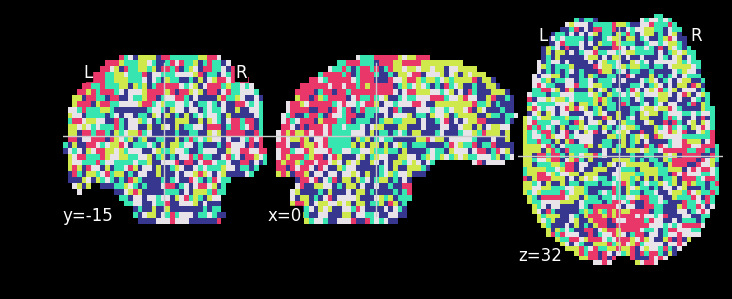

In [50]:
plotting.plot_roi(clust_img,mask_file)